In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'


In [29]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path as path
from pathlib import Path
from PIL import Image
import torch
import pytorch_lightning as pl

import xarray
import xrspatial.multispectral as ms

import math
import glob

from cloud_seg.utils import chip_vis

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_MOST_SIMILAR = DATA_DIR / 'cloudless_most_similar/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'
DATA_DIR_OUT = DATA_DIR / "model_training/"

PREDICTION_DIR = Path.cwd().parent.resolve() / "trained_models/unet/4band_originaldata_efficientnet-b0_dice__Normalize_VerticalFlip_HorizontalFlip_RandomRotate90/predictions/"

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new"

TRAIN_LABELS = DATA_DIR / "train_labels"

BANDS = ["B02", "B03", "B04", "B08"]
BANDS_NEW = []
# BANDS_NEW = ["B01", "B11"]

assert TRAIN_FEATURES.exists(), TRAIN_LABELS.exists()


def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return im_arr

def to_xarray(im_arr):
    """Put images in xarray.DataArray format"""

    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(img, use_bands=["B04", "B03", "B02"]):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    
    red = to_xarray(img[use_bands[0]])
    green = to_xarray(img[use_bands[1]])
    blue = to_xarray(img[use_bands[2]])
    
    return ms.true_color(r=red, g=green, b=blue, c=10.0, th=0.125)

    
def load_image(chip_id, bands=["B02", "B03", "B04", "B08"],
               data_dir=TRAIN_FEATURES, data_dir_new=TRAIN_FEATURES_NEW):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""

    original_bands=["B02", "B03", "B04", "B08"]

    # chip_image = np.zeros((len(want_bands), npix[0], npix[1]), dtype=np.uint16)
    chip_image = {}

    for i, band in enumerate(bands):
        if band in original_bands:
            chip_dir = data_dir / chip_id
        else:
            chip_dir = data_dir_new / chip_id

        chip_image[band] = np.array(get_array(chip_dir / f"{band}.tif")).astype(np.float32)

    return chip_image


def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # assert df["label_path"].path.exists().all()

    return df


In [45]:
import numpy as np
from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump, load
from cloud_seg.io.features import *
from cloud_seg.models.features.utils import intersection_over_union
from cloud_seg.models.features.plotting import plot_validation, BANDS

bands = ['B02', 'B03', 'B04', 'B08',
         'B05', 'B06', 'B07','B09',
         'B8A', 'B11', 'B12', 'B01']
nbands_per_file = 4
DATA_DIR = Path('../data/big_numpy_arrays/nchips_100/')

clf = load('../trained_models/features/gbm_defaultfeatures_20220119.joblib')

# labels = np.load(DATA_DIR/'train_labels_seed0.npy')
default_feature_list = ['B04', 'B03-B11', 'B08-B04', 'B08/B03',
                        'B02/B11', 'B08/B11', 'B02/B04']

file_name = '011600_011700'
file_name = '000000_000100'

# default_features = Features()
# for feature in default_feature_list:
#     default_features.add(feature)

val_labels = np.load(DATA_DIR/f"labels_{file_name}.npy").reshape(-1)
val_features = Features(
    set_type='val',
    file_name=file_name,
    data_dir=DATA_DIR,
)
for feature in default_feature_list:
    val_features.add(feature)

In [46]:
val_predictions = clf.predict(val_features.get_values())
print(intersection_over_union(val_predictions, val_labels))


0.8611065454111003


In [49]:
val_images = np.zeros((val_features.value.shape[0], len(BANDS)))
for i, band in enumerate(BANDS):
    val_images[:, i] = get_band(band, validation=True, name=file_name, data_dir=DATA_DIR)



/pscratch/sd/g/gstein/machine_learning/cloud-segmentation/cloud_seg/models/features/plotting.py:46: UserWarning: No contour levels were found within the data range.
  ax[pidx, 2].contour(labels[imidx], vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))
/pscratch/sd/g/gstein/machine_learning/cloud-segmentation/cloud_seg/models/features/plotting.py:46: UserWarning: No contour levels were found within the data range.
  ax[pidx, 2].contour(labels[imidx], vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))
/pscratch/sd/g/gstein/machine_learning/cloud-segmentation/cloud_seg/models/features/plotting.py:46: UserWarning: No contour levels were found within the data range.
  ax[pidx, 2].contour(labels[imidx], vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))
/pscratch/sd/g/gstein/machine_learning/cloud-segmentation/cloud_seg/models/features/plotting.py:46: UserWarning: No contour levels were found within the data range.
  ax[pidx, 2].contour(labels[imidx], vmin=0, vmax=1, cmap=plt.get_cmap('Reds'))
/pscratch/sd/g/gstei

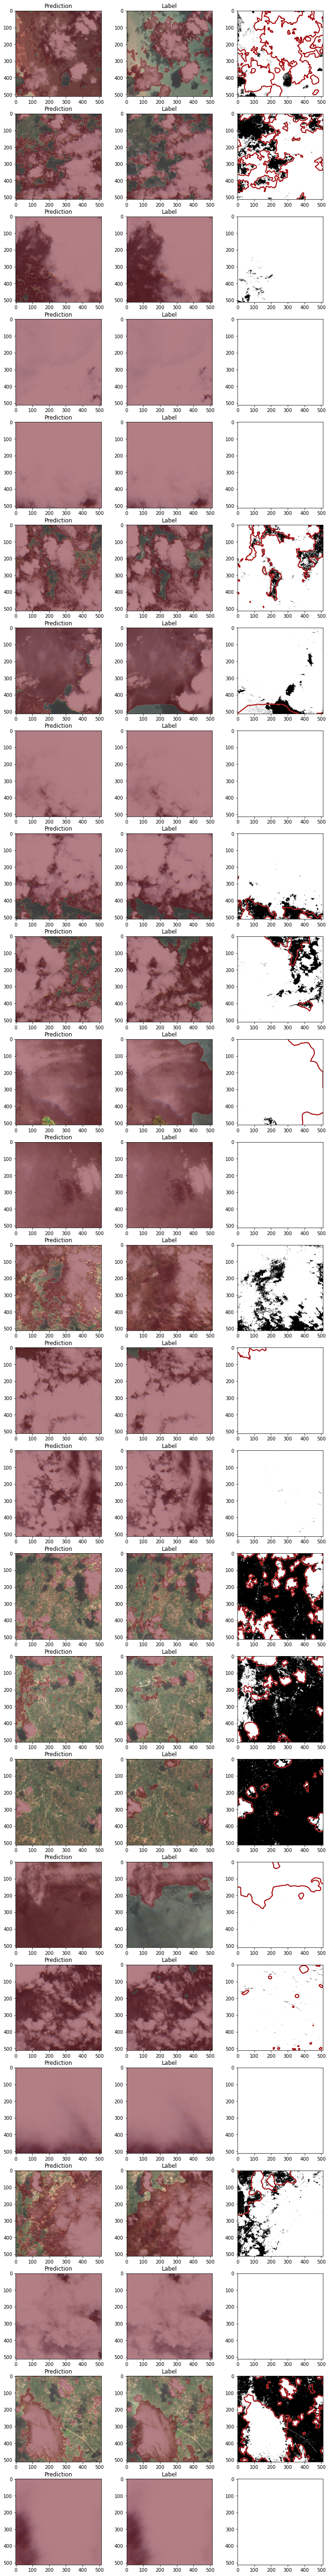

In [52]:
fig = plot_validation(val_images, val_labels, val_predictions, 25)


In [23]:
val_images.shape, val_labels.shape

((26214400, 4), (26214400,))

In [16]:
val_predictions.min(), val_predictions.max(), val_predictions[(val_predictions>0.) & (val_predictions < 1.)]

(0.0, 1.0, array([], dtype=float64))